# **Exercise 7.05**
# **Building a Convolutional Neural Network**

The dataset we will be using is a rite of passage for image classification. The images were collected for the dataset by none other than Alex Krizhevsky, Vinod Nair, and Geoffery Hinton. If these names aren’t familiar to you yet, they will be. They created the dataset CIFAR10 and CIFAR100 that you’ll be using in Activity 7.1. The dataset cosists of 60,000 images that are 32 x 32. There are 10 classes of 6,000 images each. The dataset contains 50,000 training images and 10,000 test images.
Another great thing about CIFAR10 is that we can load the datset directly from TensorFlow datasets. While it’s extremely important to spend time getting familiar with loading datasets, that isn’t the focus of this chapter. So we can benefit by being able to get going fast.


**1. Import Tensorflow**

In [0]:
import tensorflow as tf

**2. Check TensorFlow version**

In [0]:
print(tf.__version__)

2.2.0


**3. Import additional libraries.**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt


**4. Load the CIFAR10 dataset.**

In [0]:
cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()
print("x_train.shape:", x_train.shape)
print("y_train.shape", y_train.shape)


170500096/170498071 [==============================] - 6s 0us/step
x_train.shape: (50000, 32, 32, 3)
y_train.shape (50000,)


**5. Check the number of classes.**

In [0]:
K = len(set(y_train))
print("number of classes:", K)


number of classes: 10


**6. Build the model.**

In [0]:
i = Input(shape=x_train[0].shape)
x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
x = Conv2D(64, (3, 3), strides=2, activation='relu')(x)
x = Conv2D(128, (3, 3), strides=2, activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x)

model = Model(i, x)


**7. Compile the model.**

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
r = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15)


Epoch 1/15
1563/1563 [==============================] - 51s 32ms/step - loss: 1.5790 - accuracy: 0.4221 - val_loss: 1.2977 - val_accuracy: 0.5345
Epoch 2/15
1563/1563 [==============================] - 49s 32ms/step - loss: 1.2831 - accuracy: 0.5377 - val_loss: 1.1300 - val_accuracy: 0.6008
Epoch 3/15
1563/1563 [==============================] - 49s 32ms/step - loss: 1.1585 - accuracy: 0.5861 - val_loss: 1.0613 - val_accuracy: 0.6204
Epoch 4/15
1563/1563 [==============================] - 49s 31ms/step - loss: 1.0703 - accuracy: 0.6195 - val_loss: 0.9997 - val_accuracy: 0.6517
Epoch 5/15
1563/1563 [==============================] - 50s 32ms/step - loss: 0.9965 - accuracy: 0.6450 - val_loss: 0.9458 - val_accuracy: 0.6671
Epoch 6/15
1563/1563 [==============================] - 49s 31ms/step - loss: 0.9330 - accuracy: 0.6696 - val_loss: 0.9371 - val_accuracy: 0.6759
Epoch 7/15
1563/1563 [==============================] - 49s 31ms/step - loss: 0.8887 - accuracy: 0.6835 - val_loss: 0.8828 -

**8. Plot loss.**

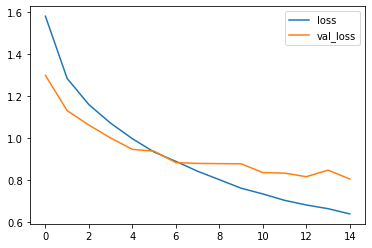

In [0]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();


**9. Plot accuracy**

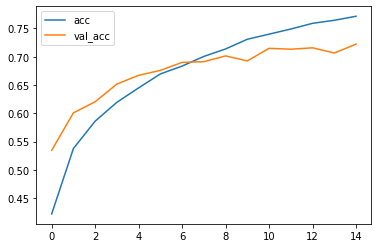

In [0]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend();


**10. Plot confusion matrix with and without normalization.**

Confusion matrix, without normalization
[[739  16  47  19  26  12  12  13  67  49]
 [ 17 810   6   8   2   1  20   5  18 113]
 [ 64   5 523  79 108  80  74  41  18   8]
 [ 12   6  48 538  70 185  72  46  11  12]
 [ 14   2  38  56 701  36  54  84  12   3]
 [  8   4  29 168  51 627  36  67   3   7]
 [  1   2  28  61  43  26 827   7   5   0]
 [  8   0  19  30  64  52   4 810   1  12]
 [ 63  27   8   9   8   7   7   6 838  27]
 [ 32  52   5  19   4   5  13  30  30 810]]


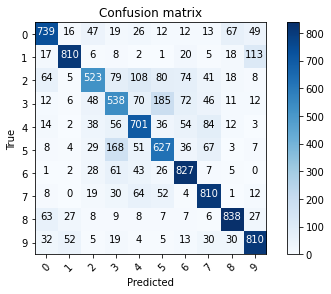

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")
	
  plt.tight_layout()
  plt.ylabel('True')
  plt.xlabel('Predicted')
  plt.show() 

pred_test = model.predict(x_test).argmax(axis=1)
c_mat = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(c_mat, list(range(10)))


**11. Label mapping.**

In [0]:
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split()


**12. Check random incorrectly classified image.**

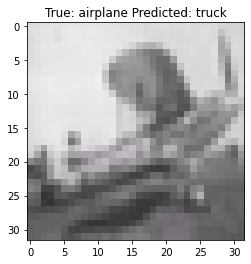

In [0]:
wrong = np.where(pred_test != y_test)[0]
i = np.random.choice(wrong)
plt.imshow(x_test[i], cmap='gray')
plt.title("True: %s Predicted: %s" % (labels[y_test[i]], labels[pred_test[i]]));
